### Clean and Package X, y Data for Model Fitting
PB 1/18/2023

In [20]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# TBD: 
# Fix PAI 
# Run kruger

# regions = ['Mpala', 'Kruger']
region = 'Mpala'
# region = 'Kruger'

# Load X Data
metricdir = Path(f'./data/out/')

# Print files in folder (just for reference
# for f in metricdir.joinpath(region).glob('*'):
    # print(f)

coverd1 = pd.read_csv(metricdir.joinpath(region).joinpath('CoverD1.csv'), index_col=0)
coverd2 = pd.read_csv(metricdir.joinpath(region).joinpath('CoverD2.csv'), index_col=0)
coverd2byH = pd.read_csv(metricdir.joinpath(region).joinpath('CoverD2byH.csv'), index_col=0)
complexity = pd.read_csv(metricdir.joinpath(region).joinpath('ComplexityMetrics.csv'), index_col=0)
perc = pd.read_csv(metricdir.joinpath(region).joinpath('PercentileHeights.csv'), index_col=0)
PAI = pd.read_csv(metricdir.joinpath(region).joinpath('FHPD2.csv'), index_col=0)
npulses = pd.read_csv(metricdir.joinpath(region).joinpath('Npulses.csv'), index_col=0)

# Open & Format y dataset for merging

# Note need to cut some blank lines from the mpala y data file
if region == 'Mpala':
    
    BiomassData = pd.read_csv(Path('./data/in/Mpala2022/MpalaGrassBiomassSurveys2022Curated.csv'))
    BiomassData = BiomassData[0:193]
    
    # Add id column to merge with x data later
    BiomassData['id'] = BiomassData['GPS #'].apply(lambda x: int(x))
    
if region == 'Kruger':
    BiomassData = pd.read_csv(Path('./data/in/LowerSabie2022/KrugerLowerSabie2022GrassBiomassCurated.csv'))
    BiomassData = BiomassData[0:60]
    
    # Make an index col for each row for kruger
    BiomassData['id'] = BiomassData['Plot #']

In [21]:
BiomassData.columns

Index(['Plot #', 'GPS #', 'Date Harvested', '% Cover', 'Height 1', 'Height 2',
       'Height 3', 'Height 4', 'Average Height', 'Wet Weight (g)',
       'Dry Weight (g)', 'Site', 'Type', 'Tree Species', 'Bag Size',
       'Average Bag Weight (g)', 'Wet Weight Without Bag (g)',
       'Dry Weight Without Bag (g)', 'Water Weight (g)', 'Max Height (cm)',
       'Max Height (m)', 'id'],
      dtype='object')

In [22]:
# BiomassData['id']

In [23]:
# BiomassData['id'], BiomassData['Plot #']

(-0.1, 2.0)

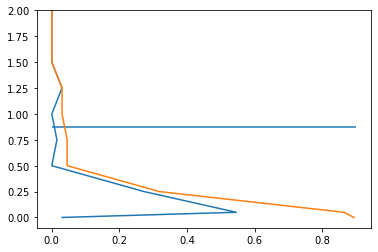

In [24]:
# Testing 
if region == 'Mpala':
    
    featid = 'Mpala01-4'
else:
    featid = 'KrugerLowerSabie2022-A11'

# Test plot of mpala cover data
fig, ax = plt.subplots()
ax.plot(coverd2byH[featid], coverd2byH[featid].index)
ax.plot(coverd2[featid], coverd2[featid].index)

# Add herbaceous layer height
ax.hlines(complexity[featid].loc['herbh'], xmin=0, xmax=0.9)
ax.set_ylim(-0.1, 2)


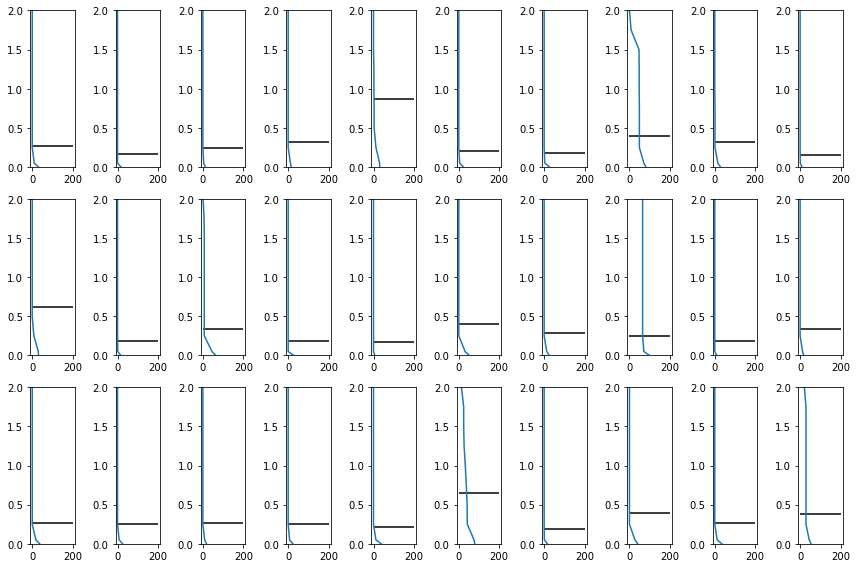

In [25]:

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 8))

axes_list = [ax for row in axes for ax in row]

ids = [featid for featid in npulses.keys()]

for ax, featid in zip(axes_list, ids[:30]):
    
        # add every single subplot to the figure with a for loop
        ax.plot(npulses[featid], npulses[featid].index)

        # Add herbaceous layer height
        ax.hlines(complexity[featid].loc['herbh'], xmin=0, xmax=200, color='k')
        
        ax.set_ylim(0, 2)
        
plt.tight_layout()
plt.show()


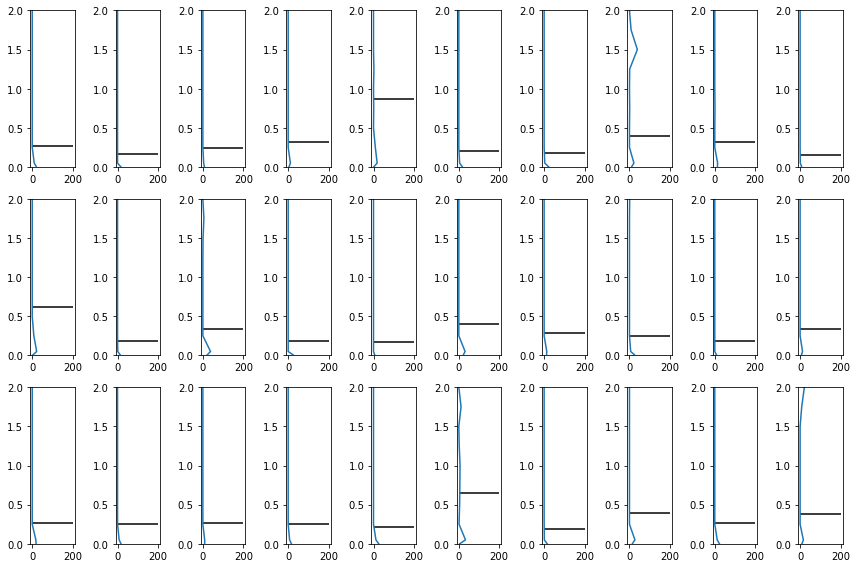

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 8))

axes_list = [ax for row in axes for ax in row]

ids = [featid for featid in npulses.keys()]

for ax, featid in zip(axes_list, ids[:30]):
    
        points = -np.diff(npulses[featid])
        
        # add every single subplot to the figure with a for loop
        ax.plot(points, npulses[featid].index[:-1])

        # Add herbaceous layer height
        ax.hlines(complexity[featid].loc['herbh'], xmin=0, xmax=200, color='k')
        
        ax.set_ylim(0, 2)
        
plt.tight_layout()
plt.show()

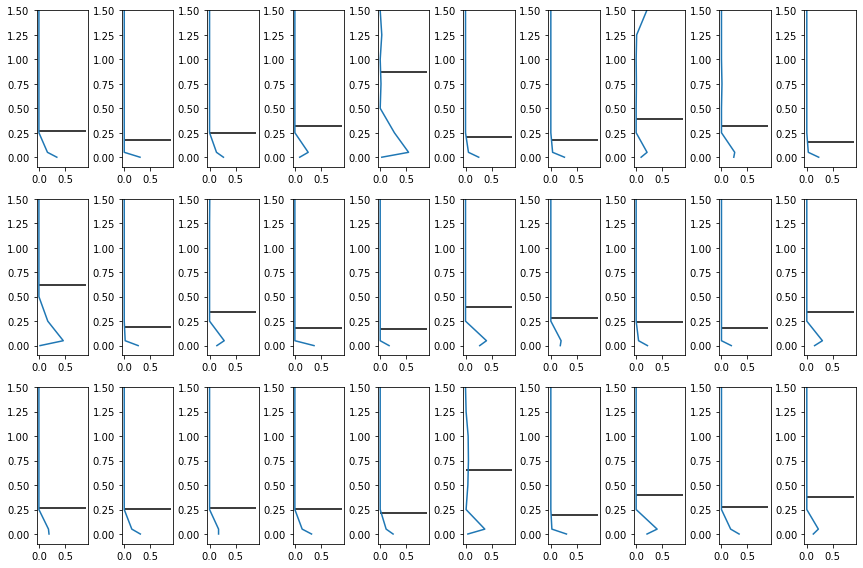

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 8))

axes_list = [ax for row in axes for ax in row]

ids = [featid for featid in npulses.keys()]

for ax, featid in zip(axes_list, ids[:30]):
    
    ax.plot(coverd2byH[featid], coverd2byH[featid].index)
    # ax.plot(coverd2[featid], coverd2[featid].index)

    # Add herbaceous layer height
    ax.hlines(complexity[featid].loc['herbh'], xmin=0, xmax=0.9, color='k')
    ax.set_ylim(-0.1, 1.5)
        
plt.tight_layout()
plt.show()


In [28]:
# Make a cover within the herbaceous layer dictionary
# Uses the caluclated herbaceous layer height to only grab cover from the top and bottom of the grass layer
cherb_dict = {'featureid':[],
              'id':[],
              'coverherb_0m':[],
              'coverherb_5cm':[],
              'cover_0m':[],
              'cover_5cm':[]}

for featid in coverd2.columns:
    
    herbh = complexity[featid].loc['herbh']

    # find indices with 2 closest values to herbh
    i = np.argsort(np.abs(coverd2.index - herbh))

    coverd2.index[i[0:2]]

    # Interpolate a cover value at the herbh
    chmax = np.interp(herbh, xp=coverd2.index, fp=coverd2[featid])

    # Get cover value at bottom
    chmin = coverd2[featid].iloc[0]

    # Also, calc at ground level (0.05 m)
    chmin_ground = coverd2[featid].iloc[1]

    # Get total cover within herbaceous layer
    # test both ground and non-ground
    cherb = chmin - chmax
    cherb_ground = chmin_ground - chmax
    
    # Append to dict
    cherb_dict['featureid'].append(featid)
    if region == 'Mpala':
        cherb_dict['id'].append(int(featid.split('-')[1]))
    elif region =='Kruger':
        cherb_dict['id'].append(featid.split('-')[1])
    cherb_dict['coverherb_0m'].append(cherb)
    cherb_dict['coverherb_5cm'].append(cherb_ground)
    cherb_dict['cover_0m'].append(chmin)
    cherb_dict['cover_5cm'].append(chmin_ground)

cherb_df = pd.DataFrame(cherb_dict)
cherb_df_t = cherb_df.transpose()
cherb_df_t.columns = cherb_df['featureid']
cherb_df_t.head()

featureid,Mpala01-13,Mpala01-1,Mpala01-2,Mpala01-3,Mpala01-4,Mpala01-5,Mpala01-6,Mpala01-7,Mpala01-8,Mpala01-9,...,Mpala15-192,Mpala15-193,Mpala15-194,Mpala15-195,Mpala15-196,Mpala15-197,Mpala15-200,Mpala15-198,Mpala15-199,Mpala07-121
featureid,Mpala01-13,Mpala01-1,Mpala01-2,Mpala01-3,Mpala01-4,Mpala01-5,Mpala01-6,Mpala01-7,Mpala01-8,Mpala01-9,...,Mpala15-192,Mpala15-193,Mpala15-194,Mpala15-195,Mpala15-196,Mpala15-197,Mpala15-200,Mpala15-198,Mpala15-199,Mpala07-121
id,13,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,200,198,199,121
coverherb_0m,0.508197,0.303571,0.398571,0.348837,0.855725,0.297425,0.282437,0.304762,0.490909,0.243963,...,0.015625,0.051724,0.0,0.0,0.189026,0.0625,0.0,0.024096,0.0,0.362319
coverherb_5cm,0.163934,0.0,0.131905,0.255814,0.825422,0.043904,0.021073,0.209524,0.254545,0.015392,...,0.0,0.0,0.0,0.0,0.03347,0.0,0.0,0.0,0.0,0.0
cover_0m,0.508197,0.303571,0.4,0.348837,0.893939,0.309859,0.295455,0.561905,0.5,0.257143,...,0.117188,0.051724,0.045455,0.0,0.2,0.0625,0.013889,0.47992,0.0,0.362319


In [29]:
# Format percentile metric df for merging
perc_t = perc.transpose()
if region == 'Mpala':
    perc_t['id'] = [int(i.split('-')[-1]) for i in perc_t.index]
elif region =='Kruger':
        perc_t['id'] = [i.split('-')[-1] for i in perc_t.index]
perc_t.head()

,0,25,50,75,98,100,mean,std,id
Mpala01-13,0.050984,0.054362,0.059458,0.063149,0.081209,0.082254,0.061687,0.009864,13
Mpala01-1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
Mpala01-2,0.053160,0.055253,0.056518,0.061774,0.074713,0.075838,0.060509,0.008965,2
Mpala01-3,0.050839,0.073447,0.110451,0.181671,0.206761,0.209809,0.121244,0.056650,3
Mpala01-4,0.053720,0.151243,0.196326,0.275715,1.270814,1.302914,0.280978,0.281088,4


In [30]:
# Make complexity for Merging
complexity_t = complexity.transpose()
if region == 'Mpala':
    complexity_t['id'] = [int(i.split('-')[-1]) for i in complexity_t.index]
elif region =='Kruger':
    complexity_t['id'] = [i.split('-')[-1] for i in complexity_t.index]

In [31]:
# Make PAI for merging

# OLD WAY commented out 1/23
# Get rid of inf values (-0)
# Also, limit to sum above 5 cm 
# PAI = PAI.iloc[1:].applymap(lambda x: 0 if x==-0 else x)

# Undoing the log(pgap)/dz here (where dz = 0.25 m) 
# and dividing by k=0.5 instead (spherical leaf angle dist.)
# Also, only taking PAI values above 0.05 m (iloc[1:])
# PAI_lim = PAI.iloc[1:].applymap(lambda x: (x*0.25)/0.5)

# REMAKE PAI here
coverd2byH_v2 = coverd2.apply(lambda x: np.abs(np.diff(x)), axis=0)
PAI_v2 = coverd2byH_v2.applymap(lambda x: -np.log(1 - x)/0.5 if x > 0 else x)

if region == 'Mpala':
    
    PAIsum_dict = {'PAIsum_0m': list(PAI_v2.sum(axis=0)),
                   'PAIsum_5cm': list(PAI_v2.iloc[1:].sum(axis=0)),
                   'PAIsum_0mto1p5m': list(PAI_v2.iloc[:8].sum(axis=0)),
                   'PAIsum_5cmto1p5m': list(PAI_v2.iloc[1:8].sum(axis=0)),
                   'PAImean_0mto1p5m': list(PAI_v2.iloc[:8].mean(axis=0)),
                   'PAImean_5cmto1p5m': list(PAI_v2.iloc[1:8].mean(axis=0)),
                    'id': [int(c.split('-')[-1]) for c in PAI_v2.columns]}
    
elif region =='Kruger':
    
    PAIsum_dict = {'PAIsum_0m': list(PAI_v2.sum(axis=0)),
                   'PAIsum_5cm': list(PAI_v2.iloc[1:].sum(axis=0)),
                   'PAIsum_0mto1p5m': list(PAI_v2.iloc[:8].sum(axis=0)),
                   'PAIsum_5cmto1p5m': list(PAI_v2.iloc[1:8].sum(axis=0)),
                   'PAImean_0mto1p5m': list(PAI_v2.iloc[:8].mean(axis=0)),
                   'PAImean_5cmto1p5m': list(PAI_v2.iloc[1:8].mean(axis=0)),
                    'id': [c.split('-')[-1] for c in PAI_v2.columns]}

PAIdf = pd.DataFrame(PAIsum_dict)

/tmp/ipykernel_40979/2010116118.py:15: RuntimeWarning: divide by zero encountered in log
  PAI_v2 = coverd2byH_v2.applymap(lambda x: -np.log(1 - x)/0.5 if x > 0 else x)


In [32]:
PAI_v2.iloc[0:8]

,Mpala01-13,Mpala01-1,Mpala01-2,Mpala01-3,Mpala01-4,Mpala01-5,Mpala01-6,Mpala01-7,Mpala01-8,Mpala01-9,...,Mpala15-192,Mpala15-193,Mpala15-194,Mpala15-195,Mpala15-196,Mpala15-197,Mpala15-200,Mpala15-198,Mpala15-199,Mpala07-121
0,0.843989,0.72358,0.620310,0.195277,0.061543,0.584776,0.605899,0.200167,0.539327,0.519022,...,0.031497,0.10622,0.0,0.0,0.338153,0.129077,0.0,0.048783,0.0,0.899834
1,0.358096,0.00000,0.286202,0.590928,1.576915,0.115975,0.069371,0.470239,0.587522,0.057975,...,0.000000,0.00000,0.0,0.0,0.090925,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.00000,0.000000,0.000000,0.636907,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.000000,0.00000,0.000000,0.000000,0.030535,0.000000,0.000000,0.009547,0.018265,0.000000,...,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.036475,0.0,0.000000
5,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
6,0.000000,0.00000,0.000000,0.000000,0.061543,0.000000,0.000000,0.019139,0.000000,0.000000,...,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
7,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.458227,0.000000,0.000000,...,0.047433,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.057030,0.0,0.000000


In [33]:
coverd2byH_v2

,Mpala01-13,Mpala01-1,Mpala01-2,Mpala01-3,Mpala01-4,Mpala01-5,Mpala01-6,Mpala01-7,Mpala01-8,Mpala01-9,...,Mpala15-192,Mpala15-193,Mpala15-194,Mpala15-195,Mpala15-196,Mpala15-197,Mpala15-200,Mpala15-198,Mpala15-199,Mpala07-121
0,0.344262,0.303571,0.266667,0.093023,0.030303,0.253521,0.261364,0.095238,0.236364,0.228571,...,0.015625,0.051724,0.0,0.0,0.155556,0.0625,0.0,0.024096,0.0,0.362319
1,0.163934,0.000000,0.133333,0.255814,0.545455,0.056338,0.034091,0.209524,0.254545,0.028571,...,0.000000,0.000000,0.0,0.0,0.044444,0.0000,0.0,0.000000,0.0,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.272727,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.015152,0.000000,0.000000,0.004762,0.009091,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.018072,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000
57,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000
58,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000
59,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.0,0.000000


In [34]:
# PAI_v2

In [35]:
# make xy dataframe, including percentile heights and cover metrics
XYdf = pd.merge(cherb_df, BiomassData)
# Add in percentile metrics (by merging on 'id' col)
XYdf = pd.merge(XYdf, perc_t)
# Add in complexity metrics
XYdf = pd.merge(XYdf, complexity_t)
# add in PAI
XYdf = pd.merge(XYdf, PAIdf)

# Add a log column
if region == 'Mpala':

    XYdf['log(DryWeight)'] =  XYdf['Dry Weight Without Bag (g)'].apply(lambda x: np.log(x) if x>0 else x)

elif region == 'Kruger':
    
    XYdf['log(DryWeight)'] =  XYdf['Dry Weight (g)'].apply(lambda x: np.log(x) if x>0 else x)

In [36]:
XYdf.columns

Index(['featureid', 'id', 'coverherb_0m', 'coverherb_5cm', 'cover_0m',
       'cover_5cm', 'Plot #', 'GPS #', 'Date Harvested', '% Cover', 'Height 1',
       'Height 2', 'Height 3', 'Height 4', 'Average Height', 'Wet Weight (g)',
       'Dry Weight (g)', 'Site', 'Type', 'Tree Species', 'Bag Size',
       'Average Bag Weight (g)', 'Wet Weight Without Bag (g)',
       'Dry Weight Without Bag (g)', 'Water Weight (g)', 'Max Height (cm)',
       'Max Height (m)', '0', '25', '50', '75', '98', '100', 'mean', 'std',
       'nlayers', 'gapsize', 'maxpeakh', 'ptoh', 'cscore', 'FHD', 'VDR',
       'VDRpeak', 'meanpeakh', 'stdpeakh', 'cvpeakh', 'herbh', 'PAIsum_0m',
       'PAIsum_5cm', 'PAIsum_0mto1p5m', 'PAIsum_5cmto1p5m', 'PAImean_0mto1p5m',
       'PAImean_5cmto1p5m', 'log(DryWeight)'],
      dtype='object')

In [37]:
# Save (using region)
XYdf.to_csv(f'./data/out/{region}/XYdata.csv')

### Extras - Plotting, Printing metrics, etc.

In [36]:
XYdf[XYdf['mean'] == 0]

,featureid,id,coverherb_0m,coverherb_5cm,cover_0m,cover_5cm,Plot #,GPS #,Date Harvested,% Cover,...,stdpeakh,cvpeakh,herbh,PAIsum_0m,PAIsum_5cm,PAIsum_0mto1p5m,PAIsum_5cmto1p5m,PAImean_0mto1p5m,PAImean_5cmto1p5m,log(DryWeight)
1,Mpala01-1,1,0.303571,0.0,0.303571,0.0,1.0,1.0,14/01/2022,15.0,...,0.0,0.0,0.172159,2.384277,0.0,2.384277,0.0,0.298035,0.0,2.137651
13,Mpala01-14,14,0.368421,0.0,0.368421,0.0,14.0,14.0,14/01/2022,25.0,...,0.0,0.0,0.183209,1.997058,0.0,1.997058,0.0,0.249632,0.0,3.482147
14,Mpala01-15,15,0.170732,0.0,0.170732,0.0,15.0,15.0,14/01/2022,10.0,...,0.0,0.0,0.168163,3.535324,0.0,3.535324,0.0,0.441915,0.0,1.894542
18,Mpala01-19,19,0.188679,0.0,0.188679,0.0,19.0,19.0,14/01/2022,20.0,...,0.0,0.0,0.183209,3.335414,0.0,3.335414,0.0,0.416927,0.0,2.958004
31,Mpala02-55,55,0.000000,0.0,0.000000,0.0,55.0,55.0,15/01/2022,10.0,...,0.0,0.0,0.183209,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.702837
32,Mpala02-54,54,0.000000,0.0,0.000000,0.0,54.0,54.0,15/01/2022,80.0,...,0.0,0.0,0.183209,0.000000,0.0,0.000000,0.0,0.000000,0.0,4.754706
35,Mpala02-58,58,0.000000,0.0,0.000000,0.0,58.0,58.0,15/01/2022,0.0,...,0.0,0.0,0.183209,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
36,Mpala02-59,59,0.527778,0.0,0.527778,0.0,59.0,59.0,15/01/2022,30.0,...,0.0,0.0,0.183209,1.278160,0.0,1.278160,0.0,0.159770,0.0,3.259615
38,Mpala02-45,45,1.000000,0.0,1.000000,0.0,45.0,45.0,15/01/2022,20.0,...,0.0,0.0,0.183209,0.000000,0.0,0.000000,0.0,0.000000,0.0,2.867302
39,Mpala02-44,44,1.000000,0.0,1.000000,0.0,44.0,44.0,15/01/2022,60.0,...,0.0,0.0,0.183209,0.000000,0.0,0.000000,0.0,0.000000,0.0,2.641162


In [42]:
featids_shortgrass = [f for f in XYdf[XYdf['mean'] == 0].featureid]

In [37]:
XYdf[XYdf['mean'] == 0].mean()

/tmp/ipykernel_25482/914070541.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  XYdf[XYdf['mean'] == 0].mean()


id                            89.271186
coverherb_0m                   0.252484
coverherb_5cm                  0.000000
cover_0m                       0.252484
cover_5cm                      0.000000
Plot #                        89.271186
GPS #                         89.271186
% Cover                       32.372881
Height 1                       5.745763
Height 2                       5.796610
Height 3                       5.864407
Height 4                       6.152542
Average Height                 5.889831
Wet Weight (g)                44.812034
Dry Weight (g)                42.874561
Average Bag Weight (g)        15.287898
Wet Weight Without Bag (g)    29.524136
Dry Weight Without Bag (g)    26.133288
Water Weight (g)               3.390847
Max Height (cm)               10.576271
Max Height (m)                 0.105763
0                              0.000000
25                             0.000000
50                             0.000000
75                             0.000000


In [18]:
for f in metricdir.joinpath(region).glob('*'):
    print(f)

data/out/Mpala/.ipynb_checkpoints
data/out/Mpala/CoverD1.csv
data/out/Mpala/featureid_Metrics.shx
data/out/Mpala/FHPD1.csv
data/out/Mpala/CoverD2.csv
data/out/Mpala/PercentileHeights.csv
data/out/Mpala/Npulses.csv
data/out/Mpala/ComplexityMetrics.csv
data/out/Mpala/FHPD2.csv
data/out/Mpala/featureid_Metrics.prj
data/out/Mpala/featureid_Metrics.cpg
data/out/Mpala/featureid_Metrics.dbf
data/out/Mpala/XYdata.csv
data/out/Mpala/CoverD2byH.csv
data/out/Mpala/featureid_Metrics.shp
data/out/Mpala/CoverD1byH.csv


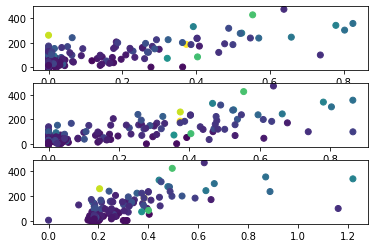

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

if region == 'Mpala':
    
    # Dry Weight Without Bag (g)
    ax1.scatter(XYdf.coverherb_5cm,
                XYdf['Dry Weight Without Bag (g)'],
                c=XYdf['Water Weight (g)'])

    ax2.scatter(XYdf.cover_5cm,
                XYdf['Dry Weight Without Bag (g)'],
                c=XYdf['Water Weight (g)'])

    ax3.scatter(XYdf['herbh'],
                XYdf['Dry Weight Without Bag (g)'],
                c=XYdf['Water Weight (g)'])
    
    
if region == 'Kruger':
    
    # Dry Weight Without Bag (g)
    ax1.scatter(XYdf.coverherb_5cm,
                XYdf['Dry Weight (g)'])

    ax2.scatter(XYdf.cover_5cm,
                XYdf['Dry Weight (g)'])

    ax3.scatter(XYdf['herbh'],
                XYdf['Dry Weight (g)'])

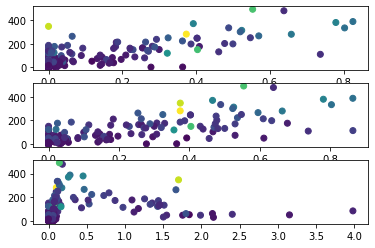

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# Dry Weight Without Bag (g)
ax1.scatter(XYdf.coverherb_5cm,
            XYdf['Wet Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

ax2.scatter(XYdf.cover_5cm,
            XYdf['Wet Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

ax3.scatter(XYdf['mean'],
            XYdf['Wet Weight Without Bag (g)'],
            c=XYdf['Water Weight (g)'])

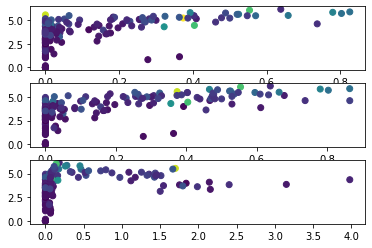

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# Dry Weight Without Bag (g)
ax1.scatter(XYdf.coverherb_5cm,
            XYdf['log(DryWeight)'],
            c=XYdf['Water Weight (g)'])

ax2.scatter(XYdf.cover_5cm,
            XYdf['log(DryWeight)'],
            c=XYdf['Water Weight (g)'])

ax3.scatter(XYdf['mean'],
            XYdf['log(DryWeight)'],
            c=XYdf['Water Weight (g)'])

In [22]:
# MI.loc['Dry Weight Without Bag (g)']

In [23]:
# MI.loc['Wet Weight Without Bag (g)']

In [24]:
corr = pairwise_corr(XYdf.select_dtypes(include=np.number), drop_nan=True)

NameError: name 'pairwise_corr' is not defined

In [ ]:
# corr.loc['Dry Weight Without Bag (g)']

In [ ]:
# corr.loc['Wet Weight Without Bag (g)']

In [ ]:
corr.loc['log(DryWeight)'].sort_values(ascending=False)

In [ ]:
corr.loc['Dry Weight Without Bag (g)'].sort_values(ascending=False)

In [ ]:
# Check on cherb cover values vs regular cover values

In [ ]:
plt.scatter(cherb_df['cover_0m'], cherb_dict['coverherb_0m'])

In [ ]:
plt.scatter(cherb_df['cover_5cm'], cherb_dict['coverherb_5cm'])

In [ ]:
coverd2.transpose().head()

In [ ]:
sns.histplot(complexity.loc["nlayers"])

In [ ]:
sns.histplot(complexity.loc["herbh"])

In [ ]:
complexity.head()